In [11]:
%matplotlib inline

import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
import data_set
import clustering
import fit_to_external_classification
import predict_nuber_of_clusters

In [131]:
from importlib import reload

reload(data_set)
reload(clustering)
reload(predict_nuber_of_clusters)
reload(fit_to_external_classification)

<module 'fit_to_external_classification' from '/home/davidross/Documents/Unsupervised/classification-master/fit_to_external_classification.py'>

In [14]:
def pandas_reader(filename):
    """
    Reading bytes as a Pandas dataframe.
     """
    tab = pd.read_csv(filename, encoding="utf8", sep=",", dtype={"switch": np.int32})
    return tab

def get_graphs(filename_graphs) -> list[nx.classes.graph.Graph]:
    r"""Getting the graphs.
    Return types:
        * **graphs** *(List of NetworkX graphs)* - Graphs of interest.
    """
    with open(filename_graphs) as f:
        graphs = json.load(f)
    graphs = [nx.from_edgelist(graphs[str(i)]) for i in range(len(graphs))]
    return graphs

def get_target(filename_targets) -> np.array:
    r"""Getting the class membership of graphs.
    Return types:
        * **target** *(Numpy array)* - Class membership vector.
     """
    data_tab = pandas_reader(filename_targets)
    target = np.array(data_tab["target"])
    return  target

In [15]:
graphs = get_graphs("/home/davidross/Downloads/deezer_ego_nets/deezer_edges.json")
y = get_target("/home/davidross/Downloads/deezer_ego_nets/deezer_target.csv")

In [16]:
from karateclub import FeatherGraph

model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()

In [17]:
np.savetxt("graph_embedding.csv", X, delimiter=",")

In [18]:
np.savetxt("graph_target.csv", y, delimiter=",")

In [19]:
data_set_number = 2

In [73]:
dataset = data_set.prepare_data_set2()

In [74]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(dataset.drop('Target', axis=1))

/tmp/ipykernel_4238/3850962857.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)


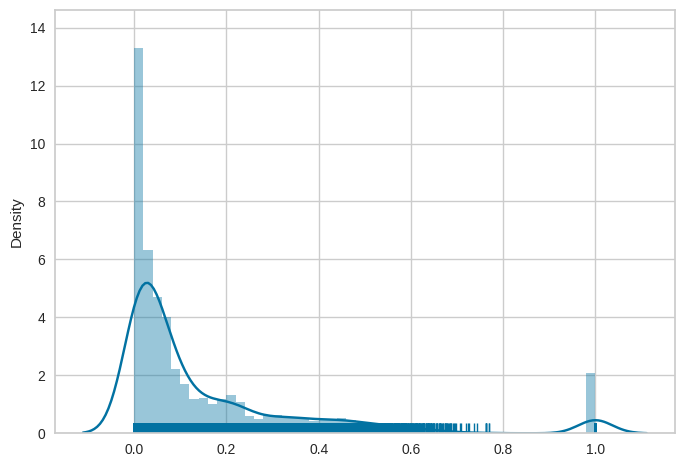

In [22]:
import seaborn as sns

sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)
plt.savefig('distplot.png')

In [26]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

In [27]:
points = np.asarray(dataset.drop('Target', axis=1))

In [28]:
from sklearn.manifold import TSNE

points_red = TSNE(n_components=2).fit_transform(points)

/home/davidross/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/davidross/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
points = scaler.fit_transform(points)
points_red = scaler.fit_transform(points_red)

In [30]:
reg_points = []
anomalous_points = []

reg_points_red = []
anomalous_points_red = []

for i in range(0, len(points)):
    if i in outliers:
        anomalous_points.append(points[i])
        anomalous_points_red.append(points_red[i])
    else: 
        reg_points.append(points[i])
        reg_points_red.append(points_red[i])
        
reg_points = np.asarray(reg_points)
anomalous_points = np.asarray(anomalous_points)

reg_points_red = np.asarray(reg_points_red)
anomalous_points_red = np.asarray(anomalous_points_red)
# print('anomalous: ', anomalous_points, len(anomalous_points))
# print('reg: ', reg_points, len(reg_points))
    
np.savetxt("dataset2_is_anomaly.csv", outliers, delimiter=",")

np.savetxt("dataset2_all_points.csv", points, delimiter=",")
np.savetxt("dataset2_reg_points.csv", reg_points, delimiter=",")
np.savetxt("dataset2_anomalous_points.csv", anomalous_points, delimiter=",")

np.savetxt("dataset2_all_points_red.csv", points_red, delimiter=",")
np.savetxt("dataset2_reg_points_red.csv", reg_points_red, delimiter=",")
np.savetxt("dataset2_anomalous_points_red.csv", anomalous_points_red, delimiter=",")

In [31]:
reg_points = np.genfromtxt("dataset2_reg_points.csv", delimiter=',')
reg_points_red = np.genfromtxt("dataset2_reg_points_red.csv", delimiter=',')
print('len of reg ', len(reg_points))

anomalous_points = np.genfromtxt("dataset2_anomalous_points.csv", delimiter=",")
anomalous_points_red = np.genfromtxt("dataset2_anomalous_points_red.csv", delimiter=",")
print('len of anomalous ', len(anomalous_points))

points = np.genfromtxt("dataset2_all_points.csv", delimiter=",")
points_red = np.genfromtxt("dataset2_all_points_red.csv", delimiter=",")

is_anomaly = np.genfromtxt("dataset2_is_anomaly.csv", delimiter=",")

len of reg  8666
len of anomalous  963


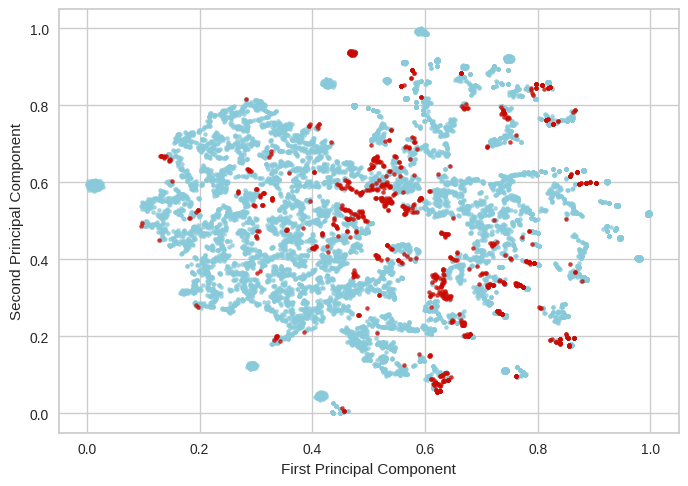

In [75]:
 # plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
ax.scatter(reg_points_red[:, 0], reg_points_red[:, 1], c='c', alpha=0.8, s=8)
plt.scatter(anomalous_points_red[:, 0], anomalous_points_red[:, 1], c='r', alpha=0.8, s=8)
plt.savefig('tsne_1.png')
plt.show()

real unique labels [0 1] 9629


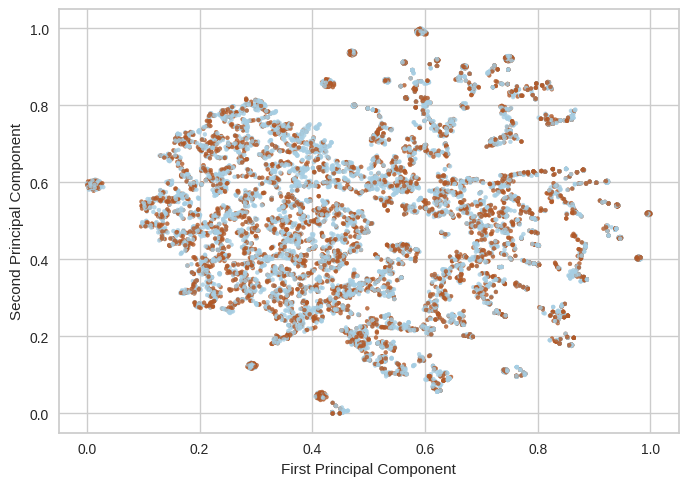

In [112]:
labels = list(dataset['Target'])
fit_to_external_classification.plot_external_tag_distribution(data_set_number, points_red, labels)

In [113]:
for i in sorted(outliers, reverse=True):
    del labels[i]

For n_clusters = 2 The average silhouette_score is : 0.38682407883156067
For n_clusters = 3 The average silhouette_score is : 0.40320102312050554
For n_clusters = 4 The average silhouette_score is : 0.39884173148986196
For n_clusters = 5 The average silhouette_score is : 0.37781599642380603
For n_clusters = 6 The average silhouette_score is : 0.3684515425363714
For n_clusters = 7 The average silhouette_score is : 0.37275623130862784


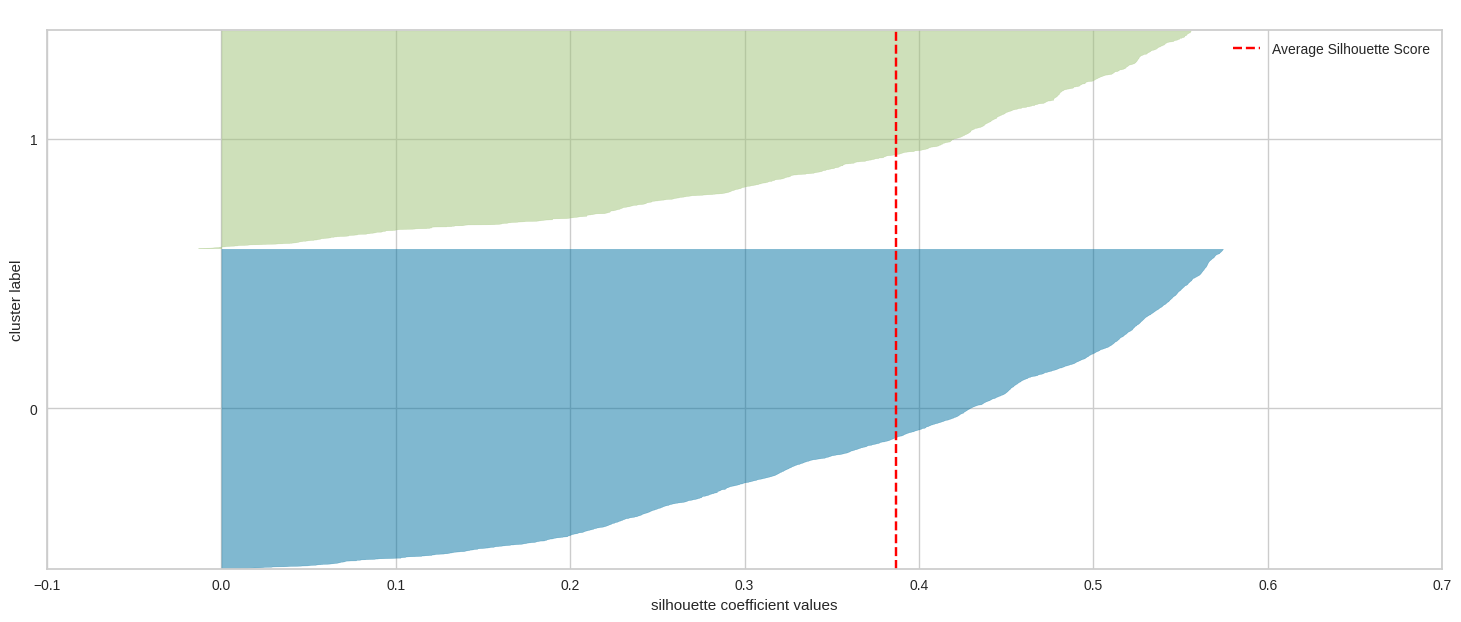

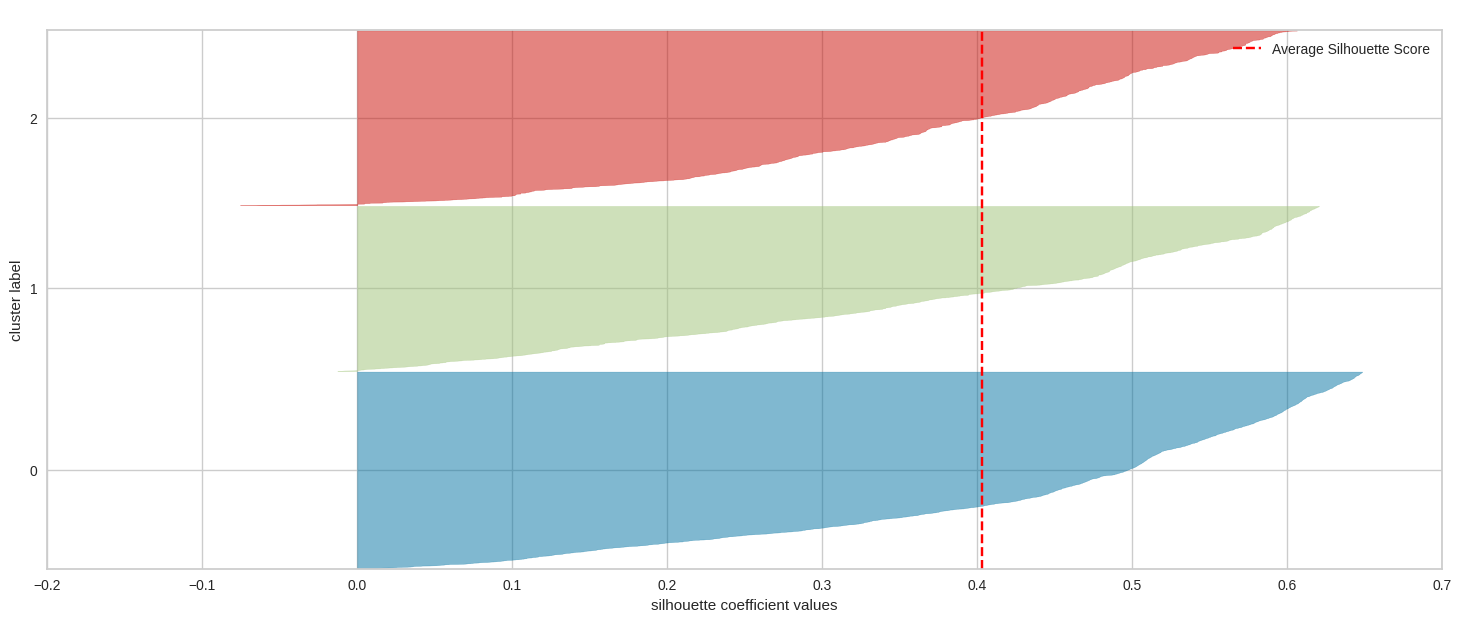

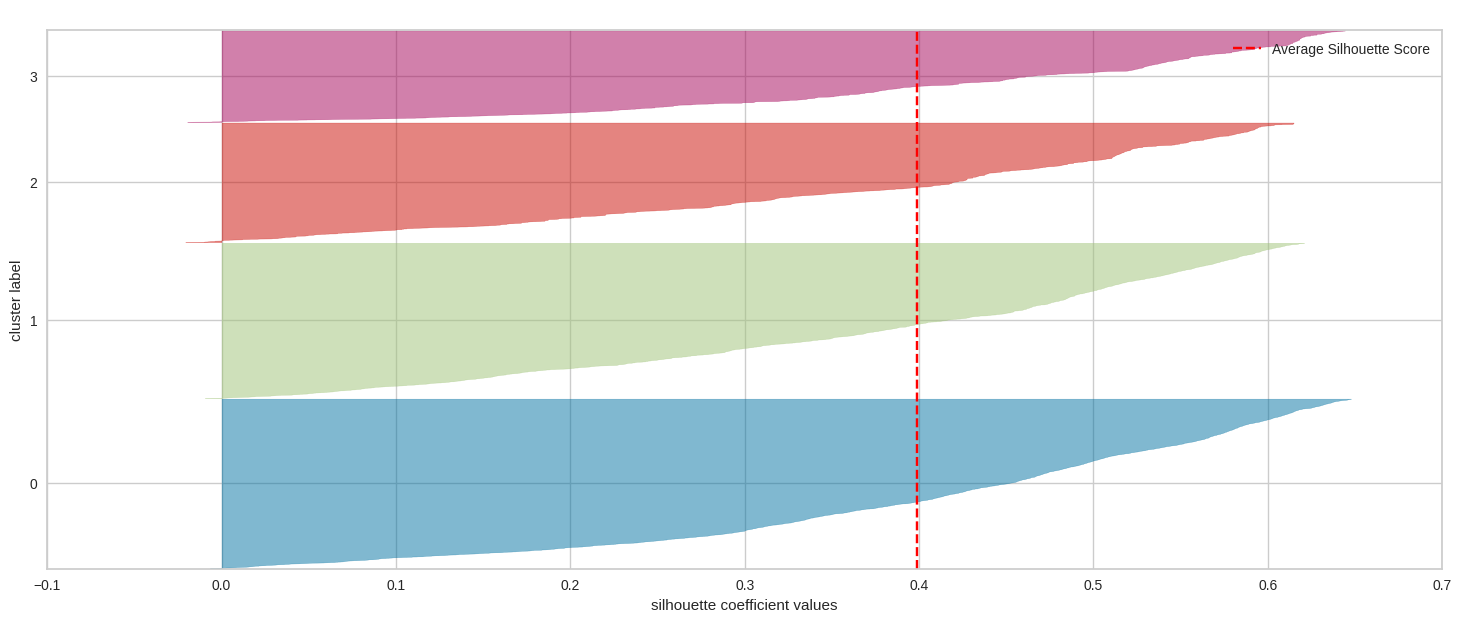

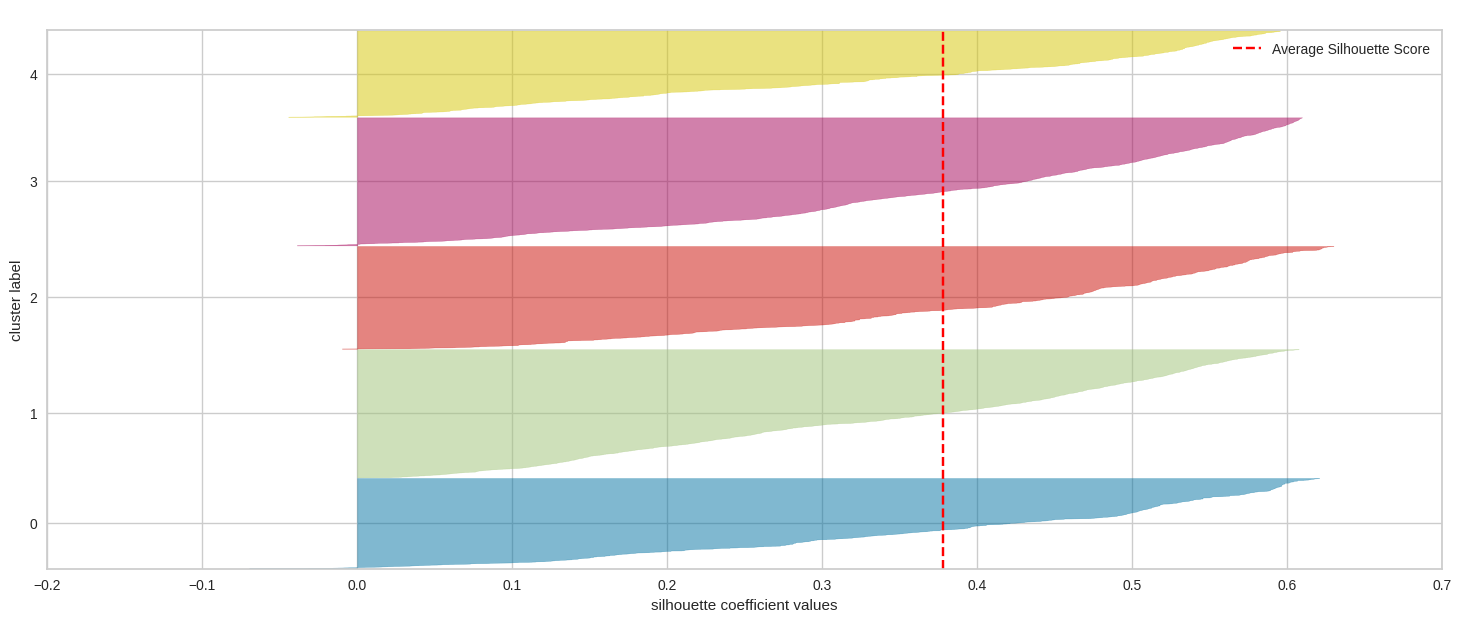

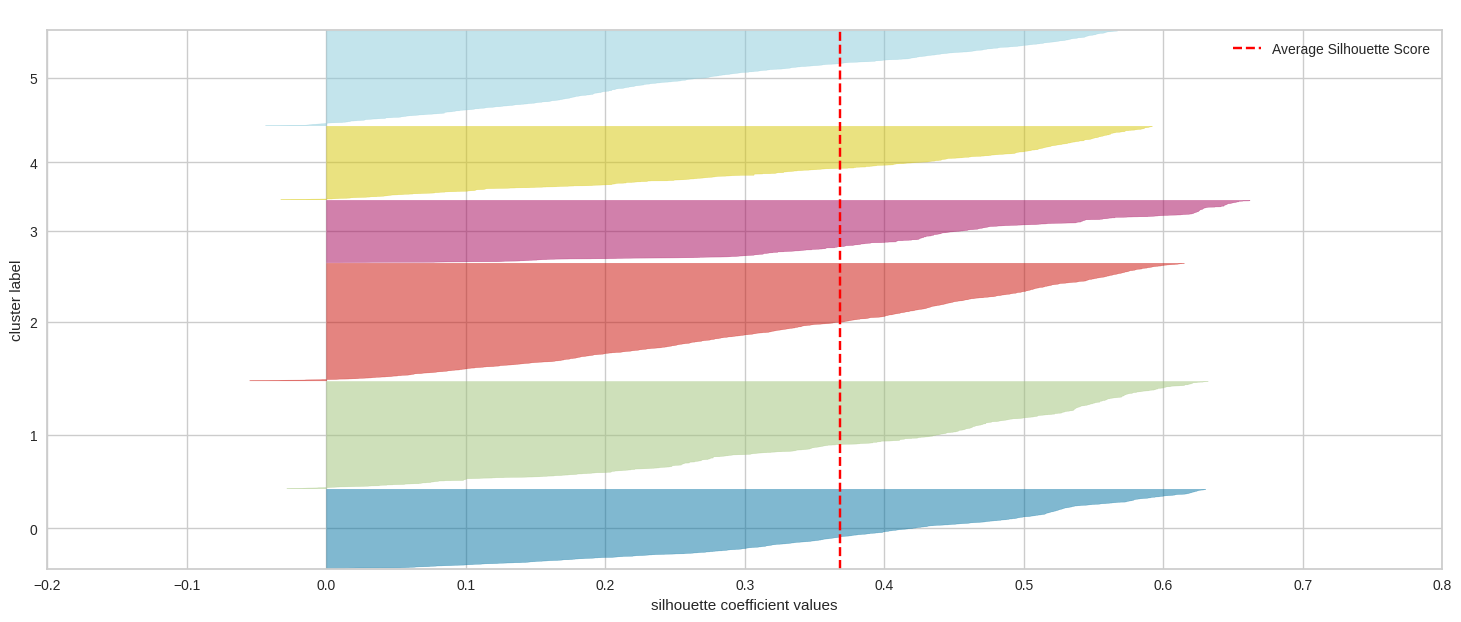

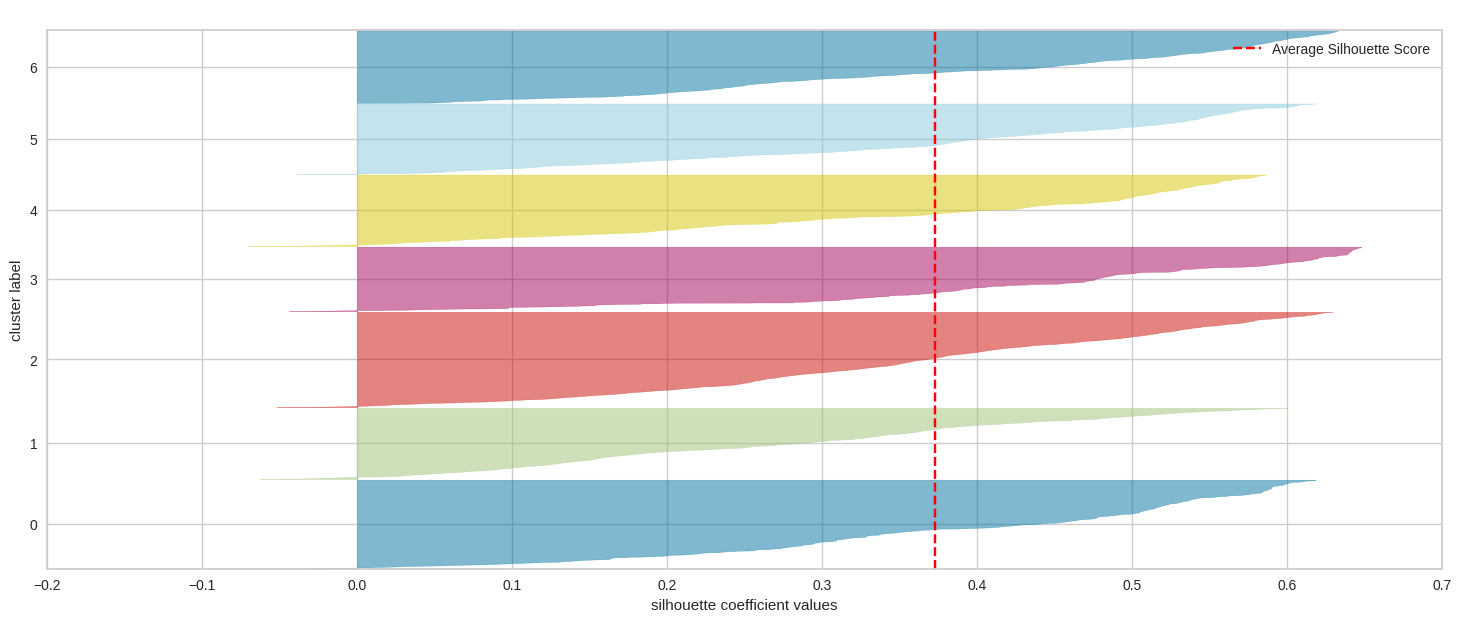

In [77]:
predict_nuber_of_clusters.perform_silhouette_method(reg_points_red, 'K means')

For n_clusters = 2 The average silhouette_score is : 0.3844716714061747
For n_clusters = 3 The average silhouette_score is : 0.4030343007810746
For n_clusters = 4 The average silhouette_score is : 0.3891413457860978
For n_clusters = 5 The average silhouette_score is : 0.37467511956801797
For n_clusters = 6 The average silhouette_score is : 0.38106911789726156
For n_clusters = 7 The average silhouette_score is : 0.35477644177959194


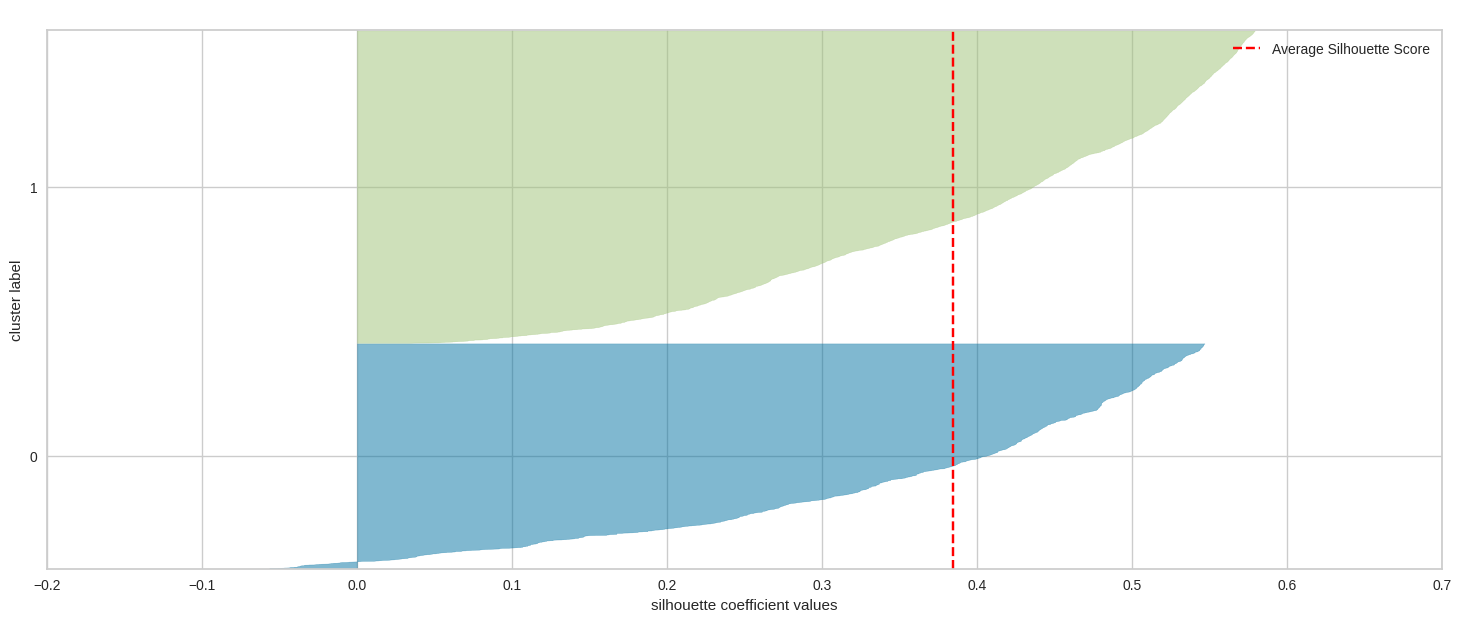

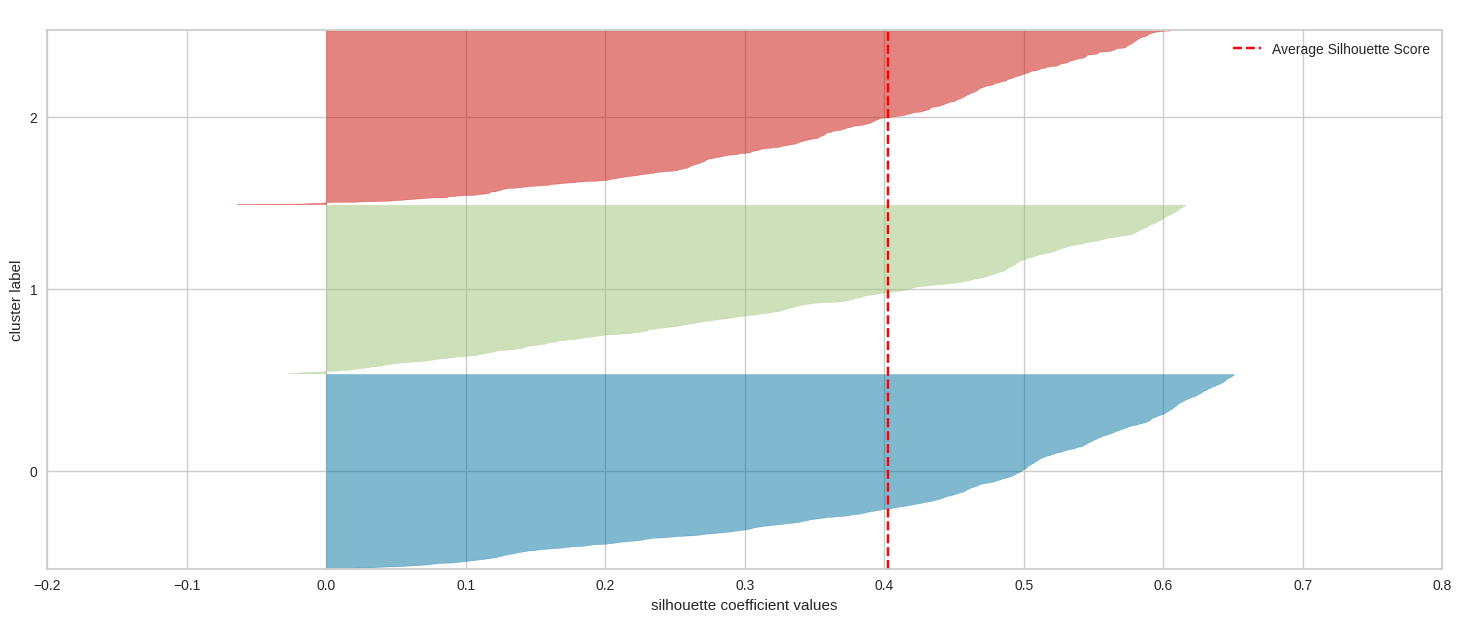

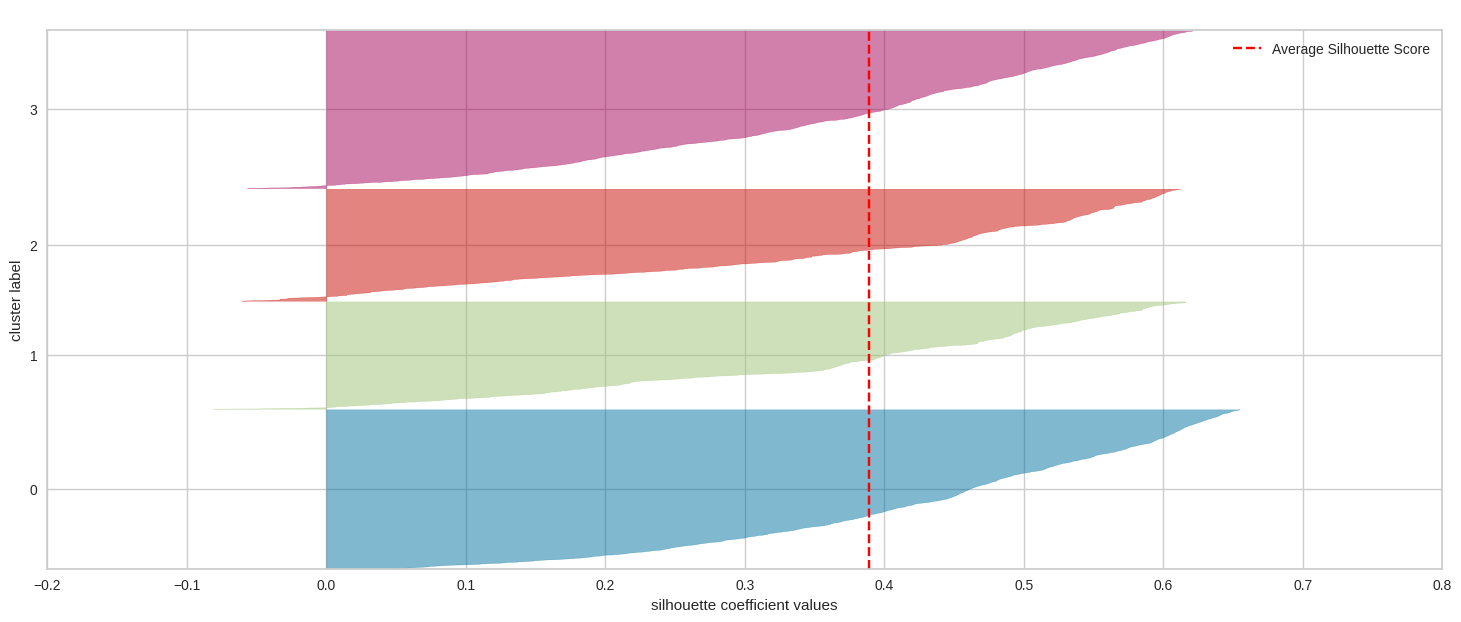

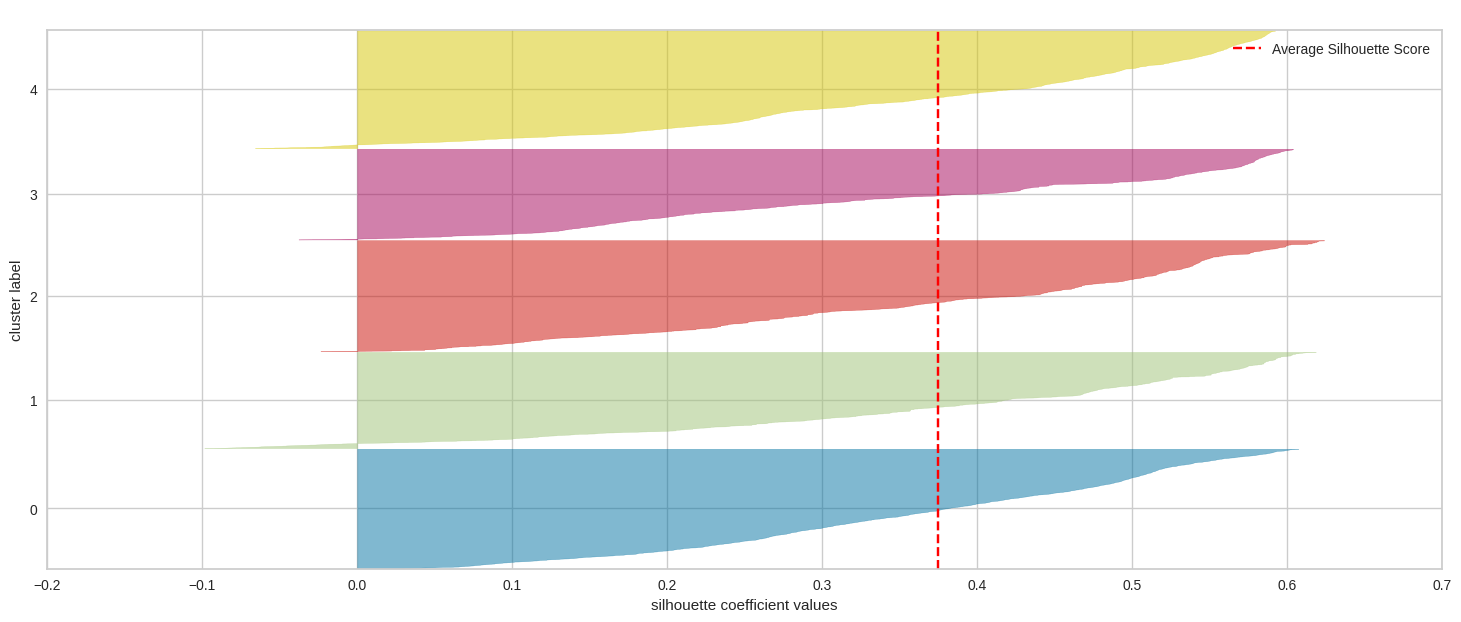

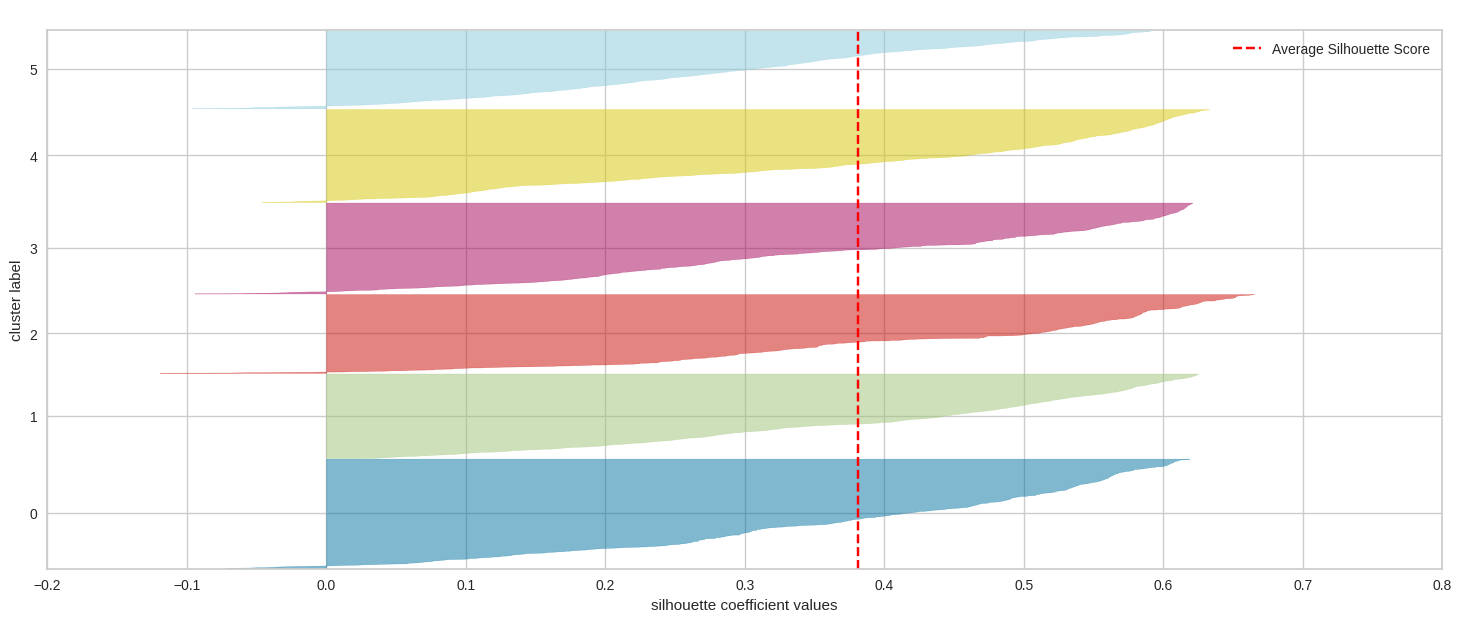

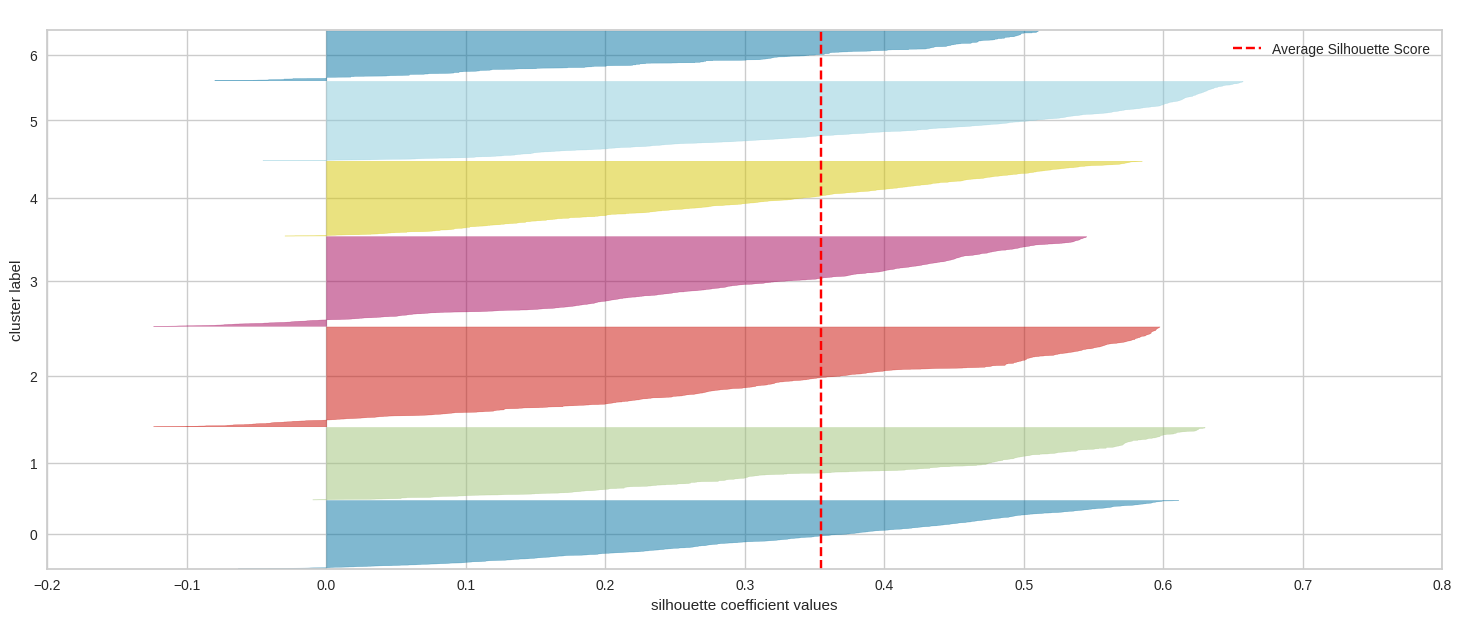

In [78]:
predict_nuber_of_clusters.perform_silhouette_method(reg_points_red, 'MiniBatchKMeans')

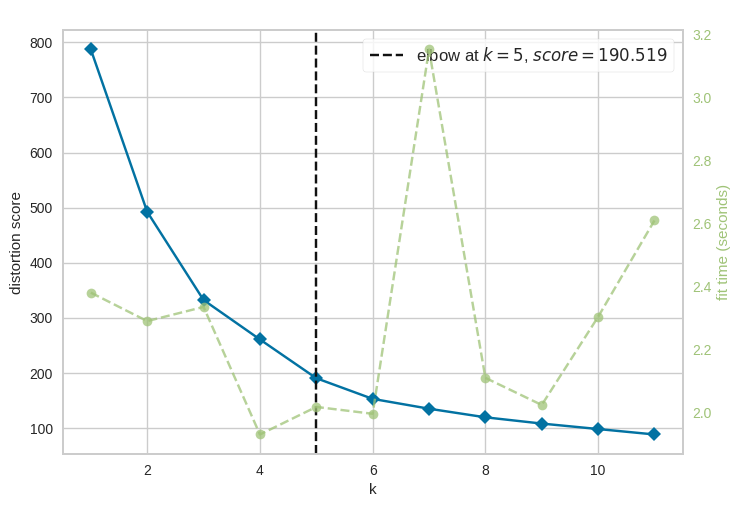

In [37]:
predict_nuber_of_clusters.perform_elbow_method(reg_points_red, 'Hierarchical')

In [38]:
methods = ['K means', 'KMeansMiniBatch', 'Hierarchical']
for method in methods:
    predict_nuber_of_clusters.compare_silhouette_scores(reg_points_red, method)

for K means    :  2 clusters are better than 5 clusters, with p value = 2.0526256330294112e-08  <<0.05
for K means    :  2 clusters are better than 6 clusters, with p value = 2.0619104585558394e-08  <<0.05
for K means    :  2 clusters are better than 7 clusters, with p value = 2.0588114513746965e-08  <<0.05
for K means    :  3 clusters are better than 2 clusters, with p value = 1.4705783563256947e-08  <<0.05
for K means    :  3 clusters are better than 4 clusters, with p value = 2.450227755737842e-08  <<0.05
for K means    :  3 clusters are better than 5 clusters, with p value = 2.4574464723046132e-08  <<0.05
for K means    :  3 clusters are better than 6 clusters, with p value = 2.4683093013112146e-08  <<0.05
for K means    :  3 clusters are better than 7 clusters, with p value = 2.4646837177509078e-08  <<0.05
for K means    :  4 clusters are better than 2 clusters, with p value = 2.046456046017672e-08  <<0.05
for K means    :  4 clusters are better than 5 clusters, with p value = 3.3

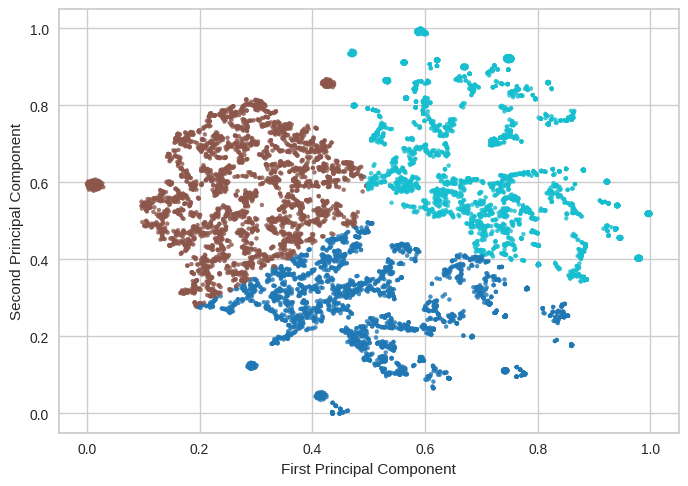

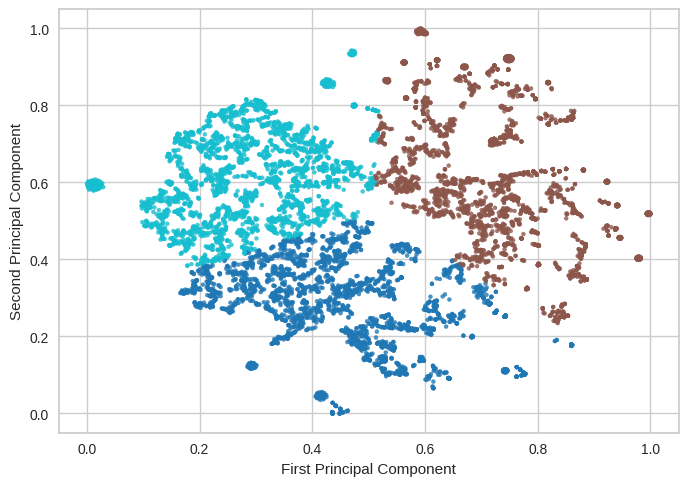

In [82]:
# cluster
clustering.plot_clustering(reg_points_red, clustering.perform_kmeans(reg_points_red, 3), 'K means')
clustering.plot_clustering(reg_points_red, clustering.perform_minibatch(reg_points_red, 3), 'MiniBatchKMeans')

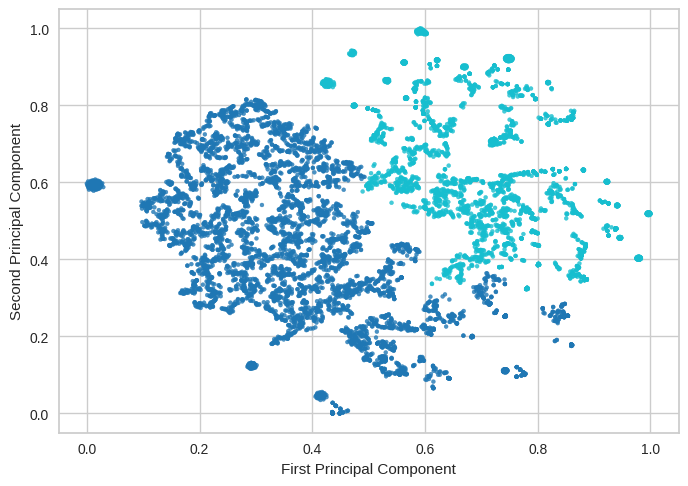

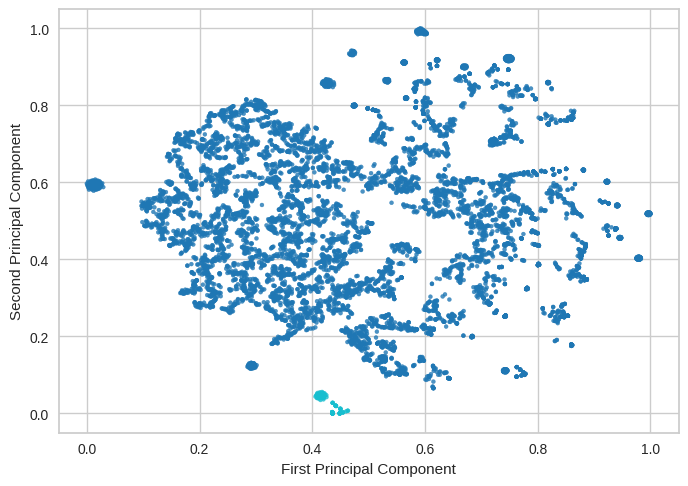

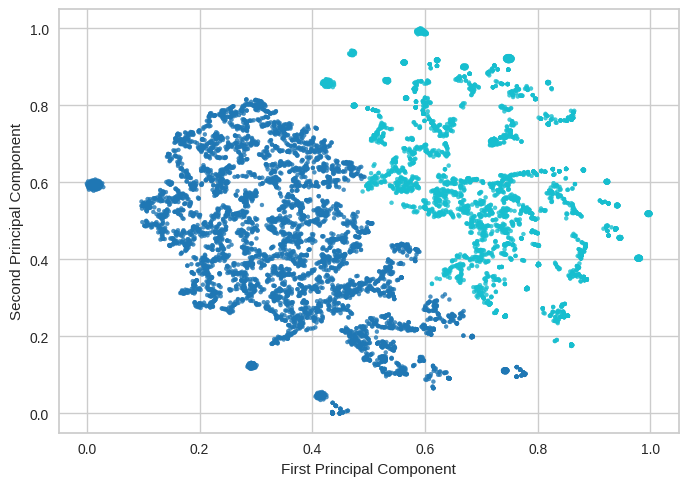

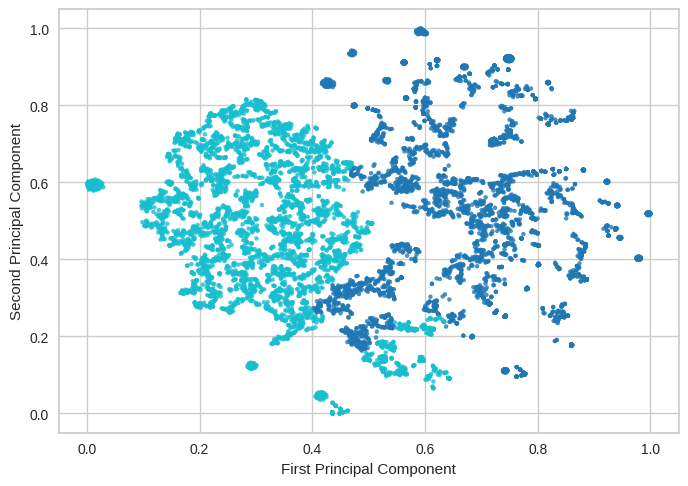

In [84]:
clustering.plot_clustering(reg_points_red, clustering.perform_hierarchical_clustering(reg_points_red, 2, 'ward'), 'Hierarchical-ward')
clustering.plot_clustering(reg_points_red, clustering.perform_hierarchical_clustering(reg_points_red, 2, 'single'), 'Hierarchical-single')
clustering.plot_clustering(reg_points_red, clustering.perform_hierarchical_clustering(reg_points_red, 2, 'average'), 'Hierarchical-average')
clustering.plot_clustering(reg_points_red, clustering.perform_hierarchical_clustering(reg_points_red, 2, 'complete'), 'Hierarchical-complete')

/home/davidross/.local/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


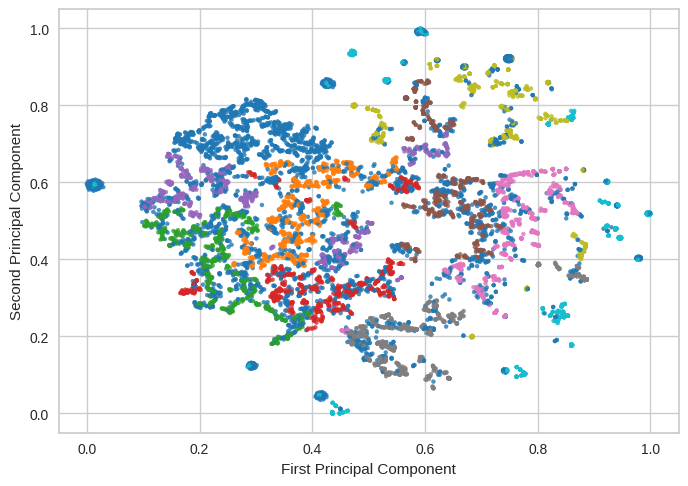

In [80]:
clustering.plot_clustering(reg_points_red, clustering.perform_optics(reg_points_red), 'OPTICS')

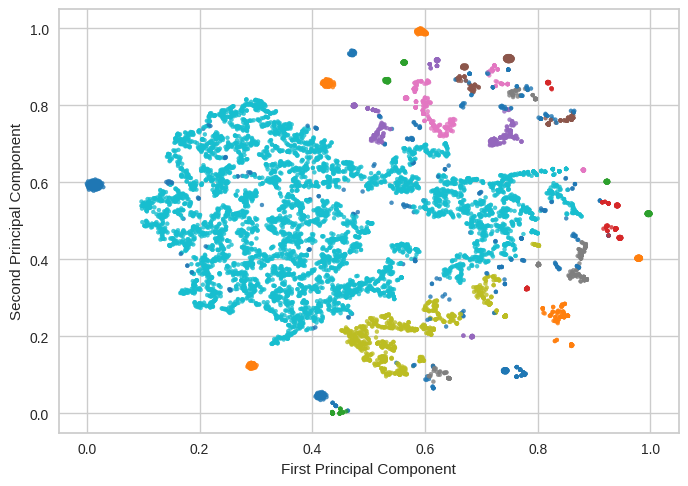

In [81]:
clustering.plot_clustering(reg_points_red, clustering.perform_hdbscan(reg_points_red), 'HDBSCAN')

In [42]:
algorithm_nmi_dictionary = {}

In [43]:
algorithm_nmi_dictionary['HDBSCAN'] = fit_to_external_classification.nmi_score(
        labels, reg_points_red, n_clusters=_, method='HDBSCAN')

In [ ]:
algorithm_nmi_dictionary['OPTICS'] = fit_to_external_classification.nmi_score(
        labels, reg_points_red, n_clusters=_, method='OPTICS')

In [45]:
algorithm_nmi_dictionary['KMeansMiniBatch'] = fit_to_external_classification.nmi_score(
        labels, reg_points_red, n_clusters=3, method='KMeansMiniBatch')

In [46]:
algorithm_nmi_dictionary['KMeans'] = fit_to_external_classification.nmi_score(
        labels, reg_points_red, n_clusters=3, method='K Means')

In [47]:
algorithm_nmi_dictionary['Hierarchical'] = fit_to_external_classification.nmi_score(
        labels, reg_points_red, n_clusters=2, method='Hierarchical')

In [48]:
algorithm_nmi_dictionary['HDBSCAN_FULL'] = fit_to_external_classification.nmi_score(
        labels, reg_points, n_clusters=_, method='HDBSCAN')

In [ ]:
algorithm_nmi_dictionary['OPTICS_FULL'] = fit_to_external_classification.nmi_score(
        labels, reg_points, n_clusters=_, method='OPTICS')

In [50]:
algorithm_nmi_dictionary['KMeansMiniBatch_FULL'] = fit_to_external_classification.nmi_score(
        labels, reg_points, n_clusters=3, method='KMeansMiniBatch')

In [51]:
algorithm_nmi_dictionary['KMeans_FULL'] = fit_to_external_classification.nmi_score(
        labels, reg_points, n_clusters=3, method='K Means')

In [52]:
algorithm_nmi_dictionary['Hierarchical_FULL'] = fit_to_external_classification.nmi_score(
        labels, reg_points, n_clusters=2, method='Hierarchical')

In [53]:
print('u test')
for key1 in algorithm_nmi_dictionary:
    for key2 in algorithm_nmi_dictionary:
        if key1 != key2:
            p_val = fit_to_external_classification.u_test(algorithm_nmi_dictionary[key1], 
                                                          algorithm_nmi_dictionary[key2])
            if p_val < 0.05:
                print(key1, 'is significantly better than ', key2, 'with p-value =', p_val, ' <<0.05')
                

u test
HDBSCAN is significantly better than  KMeansMiniBatch with p-value = 4.003272516972358e-09  <<0.05
HDBSCAN is significantly better than  KMeans with p-value = 2.9365653249152757e-09  <<0.05
HDBSCAN is significantly better than  Hierarchical with p-value = 2.341341179371028e-10  <<0.05
HDBSCAN is significantly better than  HDBSCAN_FULL with p-value = 2.341341179371028e-10  <<0.05
HDBSCAN is significantly better than  KMeansMiniBatch_FULL with p-value = 4.003272516972358e-09  <<0.05
HDBSCAN is significantly better than  KMeans_FULL with p-value = 5.526190683365762e-10  <<0.05
HDBSCAN is significantly better than  Hierarchical_FULL with p-value = 2.341341179371028e-10  <<0.05
OPTICS is significantly better than  HDBSCAN with p-value = 2.341341179371028e-10  <<0.05
OPTICS is significantly better than  KMeansMiniBatch with p-value = 4.003272516972358e-09  <<0.05
OPTICS is significantly better than  KMeans with p-value = 2.9365653249152757e-09  <<0.05
OPTICS is significantly better th

In [54]:
print('Average NMI Scores:')
for key in algorithm_nmi_dictionary:
    print('for', key, 'the average NMI Score is ', sum(algorithm_nmi_dictionary[key]) / len(algorithm_nmi_dictionary[key]))

Average NMI Scores:
for HDBSCAN the average NMI Score is  0.003504670535865311
for OPTICS the average NMI Score is  0.01617668395262819
for KMeansMiniBatch the average NMI Score is  0.001070588647338698
for KMeans the average NMI Score is  0.0013340695104789532
for Hierarchical the average NMI Score is  0.0009625544422142164
for HDBSCAN_FULL the average NMI Score is  0.002890607453024024
for OPTICS_FULL the average NMI Score is  0.014292442760789396
for KMeansMiniBatch_FULL the average NMI Score is  0.0016303432603393092
for KMeans_FULL the average NMI Score is  0.0015436273765353338
for Hierarchical_FULL the average NMI Score is  0.0016888320986681259


In [57]:
algorithm_silhouette_dictionary = {}

In [58]:
algorithm_silhouette_dictionary['HDBSCAN'] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points_red, 'HDBSCAN')                                                                                           

In [ ]:
algorithm_silhouette_dictionary['OPTICS'] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points_red, 'OPTICS')

In [64]:
methods_nclusters = [['K means', 3], ['MiniBatchKMeans', 3]]
for method, n_clusters in methods_nclusters:
    algorithm_silhouette_dictionary[method] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points_red, method, n_clusters)

In [93]:
linkages = ['ward', 'average', 'complete', 'single']
for linkage in linkages:
    algorithm_silhouette_dictionary['Hierarchical' + linkage] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points_red,
                                                                                                                        'Hierarchical',
                                                                                                                        n_clusters=2,
                                                                                                                        linkage=linkage)

In [66]:
algorithm_silhouette_dictionary['HDBSCAN_FULL'] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points, 'HDBSCAN')                                                                                           

In [ ]:
algorithm_silhouette_dictionary['OPTICS_FULL'] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points, 'OPTICS')

In [68]:
methods_nclusters = [['K means_FULL', 3], ['MiniBatchKMeans_FULL', 3]]
for method, n_clusters in methods_nclusters:
    algorithm_silhouette_dictionary[method] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points, method, n_clusters)

In [94]:
linkages = ['ward', 'average', 'complete', 'single']
for linkage in linkages:
    algorithm_silhouette_dictionary['Hierarchical' + linkage + '_FULL'] = predict_nuber_of_clusters.get_20_times_silhouette_score(reg_points,
                                                                                                                                  'Hierarchical',
                                                                                                                                  n_clusters=2,
                                                                                                                                  linkage=linkage)

In [97]:
print('u test')
for key1 in algorithm_silhouette_dictionary:
    for key2 in algorithm_silhouette_dictionary:
        if key1 != key2:
            pvalue = fit_to_external_classification.u_test(algorithm_silhouette_dictionary[key1],
                                                           algorithm_silhouette_dictionary[key2])
            if pvalue < 0.05:
                print(key1, 'is significantly better than', key2, 'with p-value =', pvalue, ' <<0.05')

u test
HDBSCAN is significantly better than HDBSCAN_FULL with p-value = 2.341341179371028e-10  <<0.05
HDBSCAN is significantly better than OPTICS_FULL with p-value = 2.341341179371028e-10  <<0.05
HDBSCAN is significantly better than Hierarchicalsingle_FULL with p-value = 2.341341179371028e-10  <<0.05
OPTICS is significantly better than HDBSCAN with p-value = 2.341341179371028e-10  <<0.05
OPTICS is significantly better than HDBSCAN_FULL with p-value = 2.341341179371028e-10  <<0.05
OPTICS is significantly better than OPTICS_FULL with p-value = 2.341341179371028e-10  <<0.05
OPTICS is significantly better than Hierarchicalsingle_FULL with p-value = 2.341341179371028e-10  <<0.05
K means is significantly better than HDBSCAN with p-value = 2.638448818274087e-09  <<0.05
K means is significantly better than OPTICS with p-value = 2.638448818274087e-09  <<0.05
K means is significantly better than Hierarchicalward with p-value = 2.638448818274087e-09  <<0.05
K means is significantly better than Hi

In [98]:
print('Average Silhouette Scores:') 
dic = {k: sum(v)/len(v) for k, v in sorted(algorithm_silhouette_dictionary.items(), key=lambda item: sum(item[1]))}
for key in dic:
    print('for', key, 'the average Silhouette Score is ', dic[key])

Average Silhouette Scores:
for OPTICS_FULL the average Silhouette Score is  -0.41000885489911026
for HDBSCAN_FULL the average Silhouette Score is  -0.09535095637009051
for Hierarchicalsingle_FULL the average Silhouette Score is  -0.04971284611999461
for HDBSCAN the average Silhouette Score is  0.018990813236358248
for OPTICS the average Silhouette Score is  0.13900952789580812
for Hierarchicalsingle the average Silhouette Score is  0.22895593717179322
for Hierarchicalcomplete the average Silhouette Score is  0.3379264200665657
for Hierarchicalward the average Silhouette Score is  0.3709796485862738
for Hierarchicalaverage the average Silhouette Score is  0.3862779820256754
for MiniBatchKMeans the average Silhouette Score is  0.40319518198832077
for K means the average Silhouette Score is  0.40319719697468814
for MiniBatchKMeans_FULL the average Silhouette Score is  0.4865320829106417
for K means_FULL the average Silhouette Score is  0.4865352845399379
for Hierarchicalaverage_FULL the a

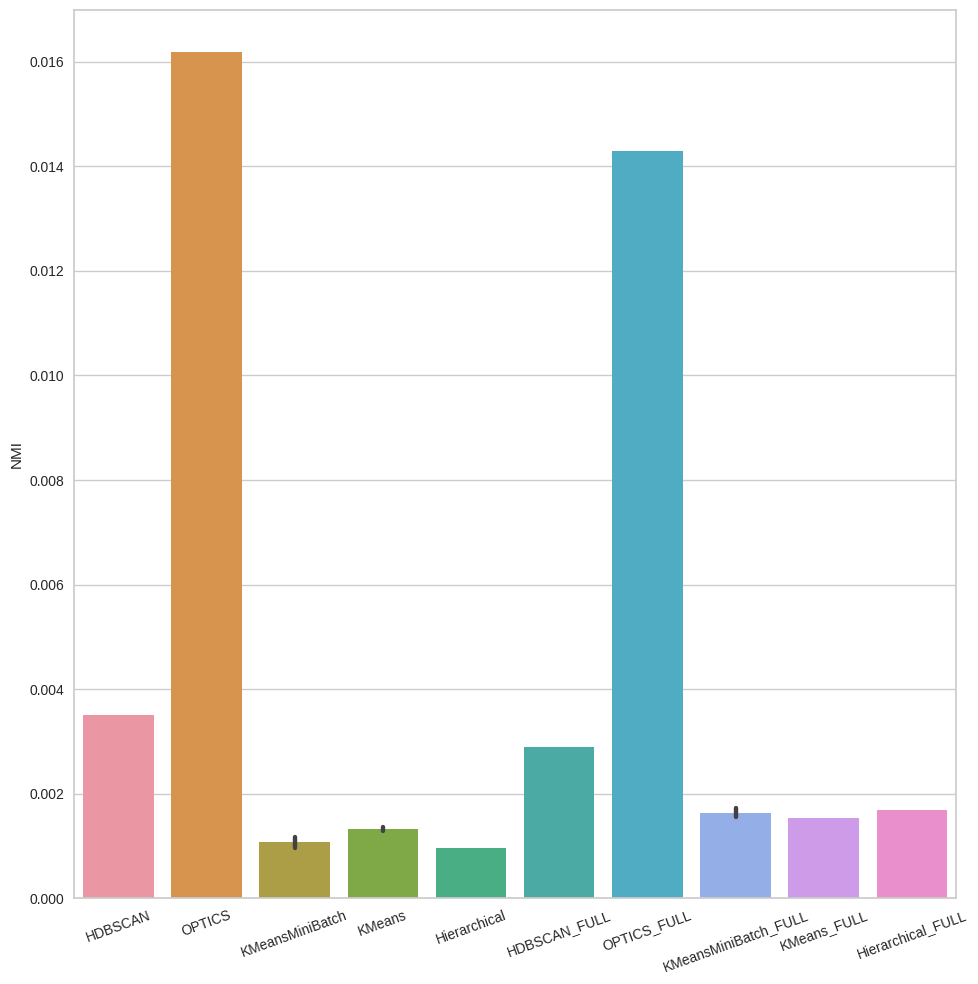

In [107]:
labels, data = [*zip(*algorithm_nmi_dictionary.items())]

plt.figure(figsize=(10, 10))
sns.barplot(data=data)
plt.ylabel('NMI')
plt.xticks(range(0, len(labels)), labels, rotation=20, ha='center')
plt.tight_layout()
plt.savefig('barplot3.png')
plt.show()

In [108]:
predictions = clustering.perform_hierarchical_clustering(reg_points_red, 2)

In [134]:
subset_points = reg_points_red[::10]
subset_labels = labels[::10]
subset_pred = predictions[::10]                                                                                                                                                                                                         

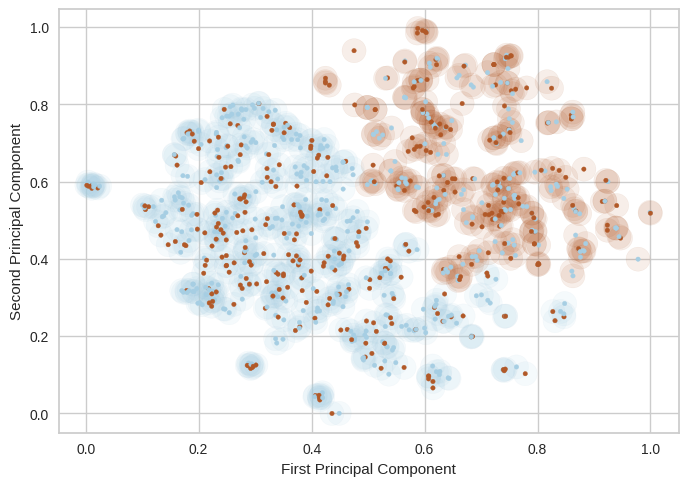

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
ax.scatter(subset_points[:, 0], subset_points[:, 1], c=subset_pred, cmap='Paired', alpha=0.1, s=300)
ax.scatter(subset_points[:, 0], subset_points[:, 1], c=subset_labels, cmap='Paired', alpha=1, s=10)
plt.savefig('vis3.png')
plt.show()